In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector

2025-06-09 19:59:10.042 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
lsb_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["validation"],
    temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR
)

In [4]:
tasks = lsb_connector.get_tasks()
dataset = lsb_connector.download_dataset(tasks)

2025-06-09 19:59:15.395 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 30 tasks available.
2025-06-09 19:59:15.396 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:125 - New `page_to` applied: 1
Loading tasks: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]
2025-06-09 19:59:15.580 | INFO     | hcmus.lbs._label_studio_connector:download_dataset:48 - No labels input, auto extract 36 labels.


In [5]:
label_dict = lsb_connector.extract_labels(tasks)

In [6]:
idx_to_label = list(label_dict.keys())
all_labels = []
for item in dataset:
    for label in item.get("target").get("labels"):
        all_labels.append(idx_to_label[label])

In [7]:
from collections import Counter
counts = Counter(all_labels)
len(counts)

36

In [8]:
import pandas as pd
from IPython.display import display, HTML

In [9]:
data = [(k, v) for k, v in counts.items()]
df = pd.DataFrame(data, columns=["Label", "Num Samples"])
df = df.sort_values("Num Samples")
display(HTML(df.to_html(index=False)))

Label,Num Samples
8935049501718-nuoc-ngot-sprite-lon-320ml,1
8936191270057-ca-phe-cappuccino-dua-just-viet-hop-hop-10-goi-x-17g,1
8935136865709-sua-tam-purite-duong-da-mem-min-huong-hoa-hong-rose-chai-850ml,1
8934563122201-mi-hao-hao-vi-tom-chua-cay-goi-100g,1
8934822801335-bia-tiger-crystal-4-6-phan-tram-lon-330ml,1
8934868166825-dau-goi-sunsilk-natural-duong-ngan-gay-rung-650g,2
8936122200276-ca-phe-mr.brown-blue-mountain-240ml,2
8935049501374-nuoc-ngot-cocacola-vi-nguyen-ban-chai-600ml,2
4902430805322-nuoc-rua-tay-diet-khuan-safeguard-trang-tinh-khiet-450ml,2
8936136163314-nuoc-mam-nam-ngu-3-trong-1-750ml,3


### Background Remove

In [5]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import cv2
import random
from typing import List, Tuple
from PIL import Image

# Load U^2-Net from Hugging Face
model = keras.saving.load_model("hf://reidn3r/u2net-image-rembg")


/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 83409.45it/s]


In [6]:
def remove_background(obj_img: np.ndarray) -> np.ndarray:
    img = cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (512, 512))
    img_norm = img_resized / 255.0

    # Model expects shape (1, 320, 320, 3)
    input_tensor = np.expand_dims(img_norm, axis=0).astype(np.float32)

    # Predict alpha matte
    pred = model(input_tensor, training=False)
    if isinstance(pred, list):
        pred = pred[0]
    pred = pred.numpy()[0, :, :, 0]
    pred = cv2.resize(pred, (obj_img.shape[1], obj_img.shape[0]))

    # Normalize and convert to 0-255 alpha
    alpha = (pred * 255).astype(np.uint8)

    # Compose RGBA
    rgba = cv2.cvtColor(obj_img, cv2.COLOR_BGR2BGRA)
    rgba[:, :, 3] = alpha
    return rgba

In [7]:
object_np = all_objects[2].get("object")
img = cv2.cvtColor(object_np, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (512, 512))
img_norm = img_resized / 255.0
input_tensor = np.expand_dims(img_norm, axis=0).astype(np.float32)
pred = model(input_tensor, training=False)[0]
mask = ((pred.numpy()[0, :, :, 0] > 0.05) * 255).astype(np.uint8)

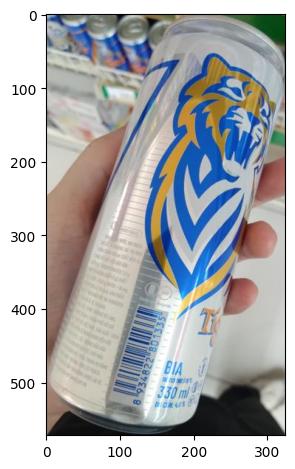

In [8]:
viz_utils.plot_image(object_np)

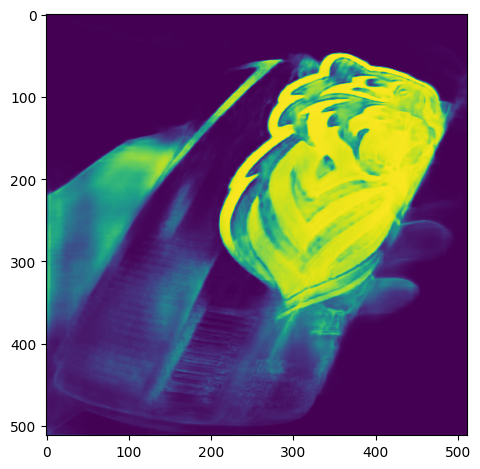

In [11]:
alpha = ((pred.numpy()[0, :, :, 0]) * 255).astype(np.uint8)
viz_utils.plot_image(alpha)

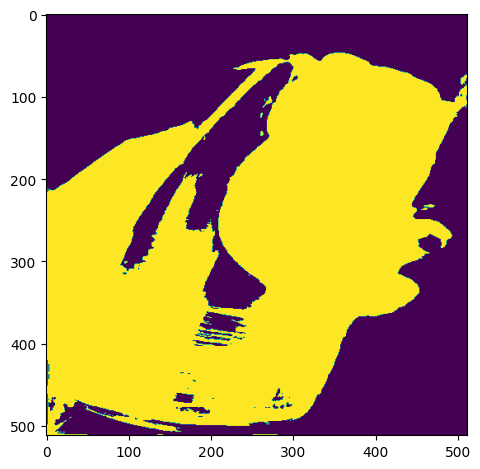

In [10]:
viz_utils.plot_image(mask)

In [ ]:
import cv2
import numpy as np

def fill_mask_holes_from_array(mask: np.ndarray, hole_area_threshold: int = 10000) -> np.ndarray:
    if mask.dtype != np.uint8:
        raise ValueError("Mask must be of dtype uint8")
    if len(mask.shape) != 2:
        raise ValueError("Mask must be a 2D array")

    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    inv_mask = cv2.bitwise_not(binary_mask)

    contours, _ = cv2.findContours(inv_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < hole_area_threshold:
            cv2.drawContours(binary_mask, [cnt], 0, 255, thickness=cv2.FILLED)

    return binary_mask


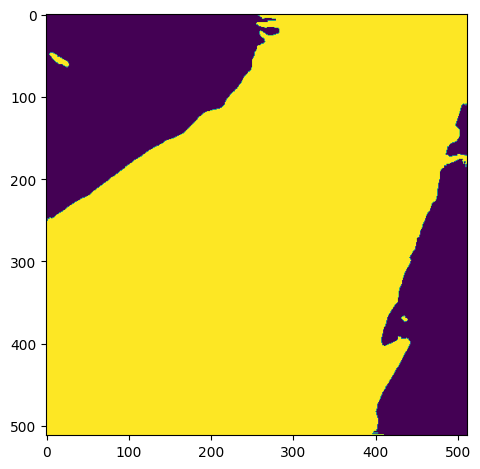

In [48]:
new_mask = fill_mask_holes_from_array(mask, 10000)
viz_utils.plot_image(new_mask)

In [31]:
import cv2
import numpy as np

def clean_and_smooth_mask(mask: np.ndarray, min_component_area: int = 5000, apply_smoothing: bool = True) -> np.ndarray:
    if mask.dtype != np.uint8 or len(mask.shape) != 2:
        raise ValueError("Input must be a 2D uint8 binary mask")

    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    cleaned_mask = np.zeros_like(binary_mask)

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_component_area:
            cleaned_mask[labels == i] = 255

    if apply_smoothing:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    return cleaned_mask


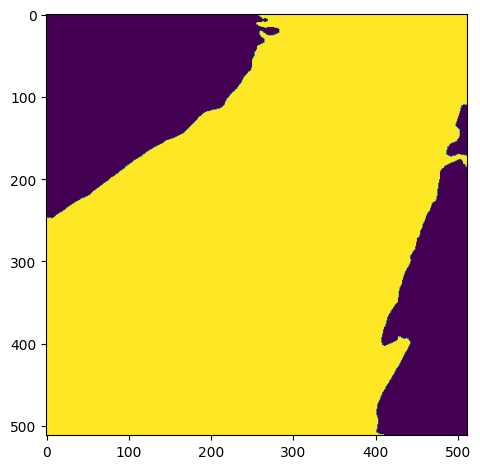

In [49]:
clean_mask = clean_and_smooth_mask(new_mask)
viz_utils.plot_image(clean_mask)

In [33]:
import numpy as np
import cv2

def apply_mask_to_image(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Image must be an RGB image (H, W, 3)")
    if mask.shape != (512, 512):
        raise ValueError("Mask must be of shape (512, 512)")

    resized_mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    _, binary_mask = cv2.threshold(resized_mask, 127, 255, cv2.THRESH_BINARY)

    mask_3ch = cv2.merge([binary_mask] * 3)

    masked_image = cv2.bitwise_and(image, mask_3ch)

    return masked_image


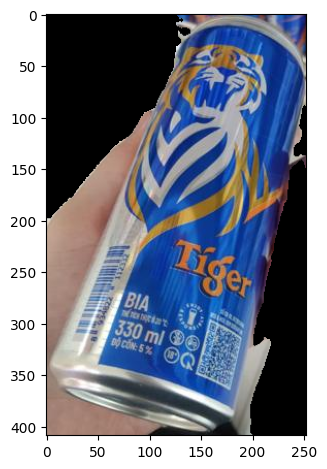

In [50]:
viz_utils.plot_image(apply_mask_to_image(object_np, clean_mask))

In [15]:
import numpy as np
import cv2

def apply_smooth_mask_to_image(image: np.ndarray, mask: np.ndarray, blur_size: int = 11) -> np.ndarray:
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Image must be an RGB image (H, W, 3)")
    if mask.shape != (512, 512):
        raise ValueError("Mask must be of shape (512, 512)")
    if mask.dtype != np.uint8:
        raise ValueError("Mask must be of dtype uint8")

    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    _, binary_mask = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)

    smooth_alpha = cv2.GaussianBlur(binary_mask, (blur_size, blur_size), 0)

    alpha = np.clip(smooth_alpha, 0, 255).astype(np.uint8)

    rgba_image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
    rgba_image[:, :, 3] = alpha

    return rgba_image


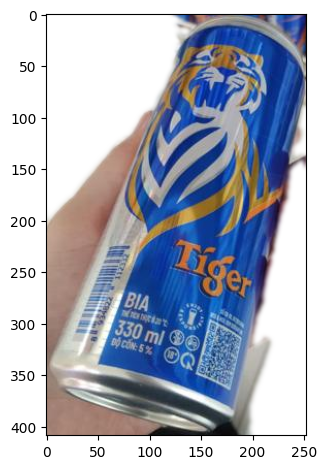

In [35]:
viz_utils.plot_image(apply_smooth_mask_to_image(object_np, clean_mask))